In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np


from scipy.fftpack import fft
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in the data
trajectory = pd.read_csv("https://raw.githubusercontent.com/jpribyl/cautious-palm-tree/master/lab4/data/trajectory_32918_3.14e-5.csv")

In [3]:
# set the relevant things
x = trajectory['x']
y = trajectory['y']

# assume 10,000 points at 250 frames / second
t = pd.Series(range(10000)) / 250

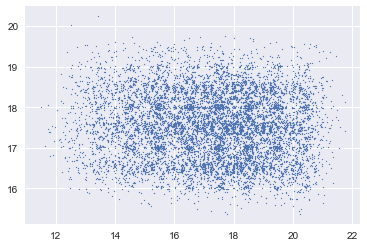

In [4]:
# set sane matplot settings
sns.set()

# visualize the distribution
plt.scatter(x, y, s=1)

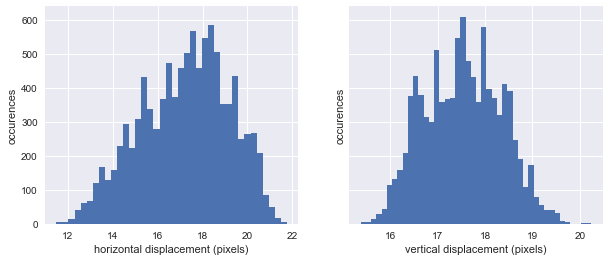

In [5]:
# build the fig and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True)

# auto-choose bins
ax1.hist(x, 'auto')
ax1.set_xlabel("horizontal displacement (pixels)")
ax1.set_ylabel("occurences")

ax2.hist(y, 'auto')
ax2.set_xlabel("vertical displacement (pixels)")
ax2.set_ylabel("occurences")

fig.set_figwidth(10)

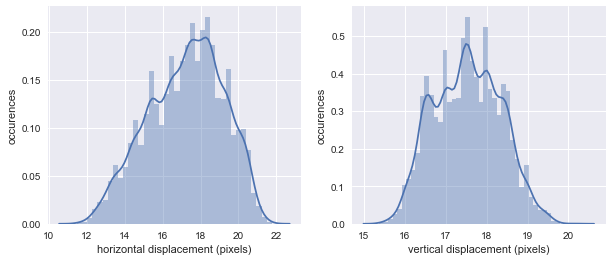

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2)

# normalized hist with a gaussian kenel density estimate
sns.distplot(x, ax=ax1)
sns.distplot(y, ax=ax2)

ax1.set_xlabel("horizontal displacement (pixels)")
ax1.set_ylabel("occurences")
ax2.set_xlabel("vertical displacement (pixels)")
ax2.set_ylabel("occurences")

fig.set_figwidth(10)

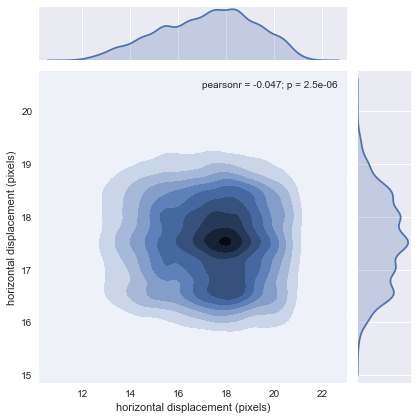

In [7]:
# a density contour plot of displacements
# IE joint probability and marginal combined
sns.jointplot(x, y, kind='kde').set_axis_labels(
    "horizontal displacement (pixels)",
    "horizontal displacement (pixels)")

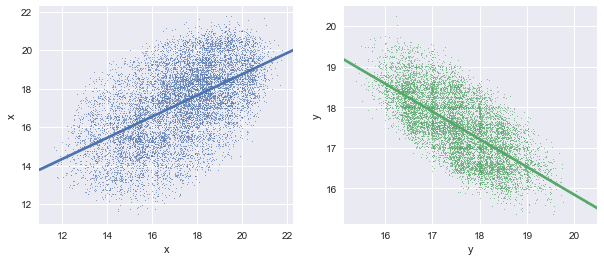

In [8]:
# see the joint probability dist
n = 5
xi = x[:-n]
xin = x[n:]
yi = y[:-n]
yin = y[n:]
fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_figwidth(10)

# fit a linear regression to the data during plotting
sns.regplot(xin, xi, scatter_kws={"s":1}, ax=ax1)
sns.regplot(yin, yi, scatter_kws={"s":1}, ax=ax2)

In [9]:
class model(object):

    """
    A class which holds models corresponding to the lab

    Attributes
    :measurementXValues: The measured X values (used to fit parameters)
    :measurementYValues: The measured Y values (used to fit parameters)
    :measurementYError: The measured y error (used to fit parameters)
    :name: the name of the model, will be displayed on plot legend

    Methods
    :model: a placeholder for the general method which will add the current
    model to a plot
    """

    def __init__(
        self,
        name='Unknown'):

        """models need a name"""
        self.name = name

    def model(self):
        """
        All models need to be able to model something
        """
        pass

class fourierModel(model):

    """
    We need to FT and model several types of input

    Attributes
    :numPoints: The number of points used during the Fourier Transform
    :sampleSpacing: How far apart the points should be
    :name: passed to model.__init__(name) as the name which shows up on plots
    """

    def __init__(self,
                 y,
                 numPoints=10000,
                 sampleSpacing=(1/250),
                 name='Fourier Model'):

        """
        :numPoints: number of points to sample
        :sampleSpacing: how far apart the sample points are

        """
        self.N = numPoints
        self.T = sampleSpacing
        self.time = np.linspace(0.0, self.N * self.T, self.N)

        self.y = y

        super(fourierModel, self).__init__(name)

    def transformX(self):
        """Produce the frequency bins for a single frequency wave
        :returns: An array with the bins for frequency (IE the x axis)

        return np.linspace(0.0, 1.0 / (2.0 * self.T), self.N//2)

        T is the spacing between points
        N is the number of points

        """

        return np.linspace(0.0, 1.0 / (2.0 * self.T), self.N//2)


    def transformY(self):
        """Transfrom the voltage of a sine function
        :returns: an array with the FT of the y function passed to the instance

        return 2.0/self.N * np.abs(fft(self.y)[0:self.N//2])
        """

        return 2.0/self.N * np.abs(fft(self.y)[0:self.N//2])


    def model(self, style='--'):
        """Transform and plot both X and Y domains
        :returns: nothing, but adds sine to current plot

        """

        plt.plot(
            self.transformX(),
            self.transformY(),
            style,
            label=self.name
        )

        return


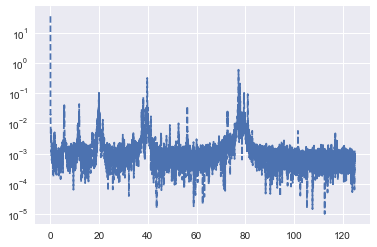

In [10]:
y_model = fourierModel(y)
y_model.model()
plt.yscale('log')

In [11]:
from bokeh.layouts import row, widgetbox
from bokeh.models import CustomJS, Slider
from bokeh.plotting import figure, output_file, show, ColumnDataSource
from bokeh.io import output_notebook
from bokeh.palettes import Category20b
from bokeh.layouts import layout

#######################
# X PLOT
#######################

source_x = ColumnDataSource(data=dict(x=x, y=x))


plot_x = figure(
    title='X Joint Probability', 
    x_axis_label="x[i] Displacement (pixels)", 
    y_axis_label="x[i + n] displacement (pixels)", 
    plot_width=400, plot_height=400
)

plot_x.scatter('x', 'y', source=source_x, size=1, color=Category20b[10][3])

callback_x = CustomJS(args=dict(source_x=source_x), code="""
    var data = source_x.data;
    var n = n.value;
    x = data['x']
    y = data['y']
    for (i = 0; i < x.length; i++) {
        y[i + n] = x[i];
    }
    source_x.change.emit();
""")

nx_slider = Slider(start=0, end=10, value=0, step=1,
                    title="n_x", callback=callback_x)
callback_x.args["n"] = nx_slider

#######################
# Y PLOT
#######################
source_y = ColumnDataSource(data=dict(x=y, y=y))

plot_y = figure(
    title='Y Joint Probability', 
    x_axis_label="y[i] displacement (pixels)", 
    y_axis_label="y[i + n] displacement (pixels)", 
    plot_width=400, 
    plot_height=400
)
plot_y.scatter('x', 'y', source=source_y, size=1, color=Category20b[10][6])

callback_y = CustomJS(args=dict(source_y=source_y), code="""
    var data = source_y.data;
    var n = n.value;
    x = data['x']
    y = data['y']
    for (i = 0; i < x.length; i++) {
        y[i + n] = x[i];
    }
    source_y.change.emit();
""")


ny_slider = Slider(start=0, end=10, value=0, step=1,
                    title="n_y", callback=callback_y)
callback_y.args["n"] = ny_slider

layout = layout([[plot_x, plot_y], [widgetbox(nx_slider, ny_slider)]])

output_notebook()

show(layout)

Loading BokehJS ...